This should be the final pipeline for the cleaning and preparing the dataset. End result is a data frame, ready to be tossed into a ML model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier


Loading the data, and convert all the strings to lower case for uniformity.

In [2]:
df_0 = pd.read_csv("../data/Training_Set_Values.csv")
df_1 = pd.read_csv("../data/Training_Set_labels.csv")
df = df_0.merge(df_1, on='id')
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].map(lambda x: x.lower() if isinstance(x, str) else x)

In [3]:
from sklearn.model_selection import train_test_split

# Replace with your actual target column name
target_col = 'status_group'  # Example: use your actual label column

X = df.drop(columns=[target_col])  # Drop target and ID from features
y = df[target_col]

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y
)


In [4]:
X_test_ids = X_test['id'].copy()  # Store before dropping


In [5]:
len(X_test_ids)

5940

In [6]:
# Columns to be dropped for the baseline models
columns_to_drop=['id','amount_tsh','num_private','recorded_by','scheme_name',
              'extraction_type_group','extraction_type_class',
              'management','payment_type','quality_group','quantity_group','source','waterpoint_type_group',
              'funder','installer','wpt_name','scheme_management']

X_test = X_test.drop(columns=columns_to_drop)
X_train = X_train.drop(columns=columns_to_drop)

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class GeoContextImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.geo_group_cols = ['subvillage', 'ward', 'lga', 'district_code', 'region_code']
        self.pop_group_cols = ['subvillage', 'ward', 'lga', 'district_code', 'region_code']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
    
        # Handle subvillage
        if 'subvillage' in X.columns:
            X['subvillage'] = X['subvillage'].replace('', pd.NA)
            X['subvillage'] = X.apply(lambda row: self.fill_subvillage(row, X), axis=1)
    
        # Handle geo columns
        for col in ['latitude', 'longitude']:
            if col in X.columns:
                X[col] = X[col].apply(lambda x: pd.NA if abs(x) < 1e-6 else x)
    
        if 'latitude' in X.columns and 'longitude' in X.columns:
            X = self.fill_missing_geo(X, self.geo_group_cols)
    
        # Handle population
        if 'population' in X.columns:
            X['population'] = X['population'].apply(lambda x: pd.NA if x in [0, 1] else x)
            X = self.fill_missing_population(X, self.pop_group_cols)
    
        # Handle gps_height and construction_year
        if 'gps_height' in X.columns:
            X['gps_height'] = X['gps_height'].apply(lambda x: pd.NA if x == 0 else x)
            X = self.geo_groupwise_fill(X, 'gps_height', self.geo_group_cols)
    
        if 'construction_year' in X.columns:
            X['construction_year'] = X['construction_year'].apply(lambda x: pd.NA if x == 0 else x)
            X = self.geo_groupwise_fill_mode(X, 'construction_year', self.geo_group_cols)
    
        # Simple fill
        if 'wpt_name' in X.columns:
            X['wpt_name'] = X['wpt_name'].fillna('none')
        if 'scheme_management' in X.columns:
            X['scheme_management'] = X['scheme_management'].fillna('other')
    
        # Relabel by coverage (robust)
        for col in ['funder', 'installer', 'scheme_name']:
            if col in X.columns:
                X = self.relabel_by_coverage(X, col, threshold=0.5)
    
        return X.replace({pd.NA: np.nan})

    def fill_subvillage(self, row, df):
        if pd.isna(row['subvillage']):
            ward_mode = df[df['ward'] == row['ward']]['subvillage'].mode()
            if not ward_mode.empty:
                return ward_mode[0]

            lga_mode = df[df['lga'] == row['lga']]['subvillage'].mode()
            if not lga_mode.empty:
                return lga_mode[0]

            district_mode = df[df['district_code'] == row['district_code']]['subvillage'].mode()
            if not district_mode.empty:
                return district_mode[0]

            return 'unknown'
        return row['subvillage']

    def fill_missing_geo(self, df, group_cols):
        for col in group_cols:
            group_means = df.dropna(subset=['latitude', 'longitude']).groupby(col)[['latitude', 'longitude']].mean()

            def fill(row):
                if pd.isna(row['latitude']) or pd.isna(row['longitude']):
                    key = row[col]
                    if key in group_means.index:
                        if pd.isna(row['latitude']):
                            row['latitude'] = group_means.loc[key, 'latitude']
                        if pd.isna(row['longitude']):
                            row['longitude'] = group_means.loc[key, 'longitude']
                return row

            df = df.apply(fill, axis=1)

            if df['latitude'].isna().sum() == 0 and df['longitude'].isna().sum() == 0:
                break

        return df

    def fill_missing_population(self, df, levels):
        for level in levels:
            group_medians = df.dropna(subset=['population']).groupby(level)['population'].median()

            def fill(row):
                if pd.isna(row['population']):
                    key = row[level]
                    if key in group_medians:
                        row['population'] = group_medians.loc[key]
                return row

            df = df.apply(fill, axis=1)
            if df['population'].isna().sum() == 0:
                break

        return df

    def geo_groupwise_fill(self, df, target_col, group_cols):
        for col in group_cols:
            group_medians = df.dropna(subset=[target_col]).groupby(col)[target_col].median()

            def fill(row):
                if pd.isna(row[target_col]):
                    key = row[col]
                    if key in group_medians.index:
                        row[target_col] = group_medians.loc[key]
                return row

            df = df.apply(fill, axis=1)
            if df[target_col].isna().sum() == 0:
                break

        return df

    def geo_groupwise_fill_mode(self, df, target_col, group_cols):
        for col in group_cols:
            group_modes = df.dropna(subset=[target_col]).groupby(col)[target_col].agg(lambda x: x.mode().iloc[0])

            def fill(row):
                if pd.isna(row[target_col]):
                    key = row[col]
                    if key in group_modes.index:
                        row[target_col] = group_modes.loc[key]
                return row

            df = df.apply(fill, axis=1)
            if df[target_col].isna().sum() == 0:
                break

        return df

    def relabel_by_coverage(self, df, column, threshold=0.5, new_label='other'):
        value_counts = df[column].value_counts(normalize=True)
        cumulative = value_counts.cumsum()
        keep_labels = cumulative[cumulative <= threshold].index.tolist()
        df[column] = df[column].apply(lambda x: x if x in keep_labels else new_label)
        return df


In [8]:
# Run the imputer manually to determine available columns
imputer = GeoContextImputer()
X_train_imputed = imputer.fit_transform(X_train.copy())

# Recompute valid column types after imputation
numeric_features = X_train_imputed.select_dtypes(include='number').columns.tolist()
categorical_features = X_train_imputed.select_dtypes(include='object').columns.tolist()

# Now define the transformers as usual
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)  # for evaluation later
len(y_test_encoded)

5940

In [20]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline  # replaces sklearn.pipeline.Pipeline
from imblearn.over_sampling import SMOTE



full_pipeline = Pipeline([
    ('context_imputer', GeoContextImputer()),  # ← Your custom logic
    ('preprocessor', preprocessor),            # ← ColumnTransformer
     ('smote', SMOTE()),
    ('classifier', RandomForestClassifier(n_estimators=300, class_weight='balanced')  # or any model
    #('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    #('classifier', DecisionTreeClassifier(class_weight="balanced")
    #('classifier', ExtraTreesClassifier(class_weight="balanced", n_estimators=200)
    #('classifier', LGBMClassifier(class_weight='balanced')
)
])


In [21]:
full_pipeline.fit(X_train, y_train_encoded)
y_pred = full_pipeline.predict(X_test)


In [22]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test_encoded, y_pred))

0.8080808080808081


In [23]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(full_pipeline, X_train, y_train_encoded, cv=5, scoring='accuracy')
print("Average CV accuracy:", scores.mean())


Average CV accuracy: 0.7964272353161241


Time to bring in the actual test set for making the submission to the competiton

In [36]:
df_3 = pd.read_csv("../data/Test_Set_Values.csv")

In [37]:
X_test_ids = df_3['id'].copy()  # Store before dropping

In [38]:
df_3 = df_3.drop(columns=columns_to_drop)

In [39]:
preds_test = full_pipeline.predict(df_3)

In [40]:
# Convert back to original string labels
y_pred_labels = le.inverse_transform(preds_test)

# Then build submission
submission = pd.DataFrame({
    "id": X_test_ids.values,
    "status_group": y_pred_labels
})
submission.to_csv("submission.csv", index=False)


Submitting resut on drivendata with testset, public score = 0.76

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'classifier__n_estimators': randint(100, 1000),
    'classifier__max_depth': [None] + list(range(10, 50, 10)),
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_dist,
    n_iter=50,             # Try 50 combinations
    cv=5,
    scoring='balanced_accuracy',    # or 'f1_macro', etc.
    random_state=42,
    n_jobs=-1,
    verbose=2
)


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

grid = GridSearchCV(
    estimator=full_pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # or 'f1_macro', etc.
    n_jobs=-1,  # parallel processing
    verbose=2
)

Optimization using gridsearch

In [25]:
random_search.fit(X_train, y_train_encoded)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Predict using the best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=171; total time= 2.4min
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=761; total time= 2.5min
[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=10, classifier__n_estimators=158; total time= 2.7min
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=230; total time= 2.0min
[CV] END classifier__bootstrap=False, classifier__max_depth=40, classifier__max_features=log2, classif

/home/amey/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=171; total time= 2.4min
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=log2, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=485; total time= 2.1min
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=121; total time= 3.1min
[CV] END classifier__bootstrap=True, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=266; total time= 3.1min
[CV] END classifier__bootstrap=False, classifier__max_depth=40, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__min_samples_split=10, class

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=798; total time=60.2min
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=798; total time=59.3min
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=798; total time=59.7min


In [26]:
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 40, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 620}
Best cross-validation score: 0.7018965084294856


Evaluation metrics

📊 Accuracy: 0.8080808080808081
🎯 Precision (macro): 0.7258044989981768
🎯 Recall (macro): 0.7065642188214794
🎯 F1 Score (macro): 0.7152602896554855
🎯 F1 Score (weighted): 0.8063079188461421
🧠 Cohen’s Kappa: 0.6479878133792702
📉 Log Loss: 0.5432239553263184
📈 ROC AUC Score (OvR): 0.8986106308429666

🧾 Classification Report:
                         precision    recall  f1-score   support

             functional       0.82      0.87      0.85      3226
functional needs repair       0.52      0.46      0.49       432
         non functional       0.83      0.79      0.81      2282

               accuracy                           0.81      5940
              macro avg       0.73      0.71      0.72      5940
           weighted avg       0.81      0.81      0.81      5940



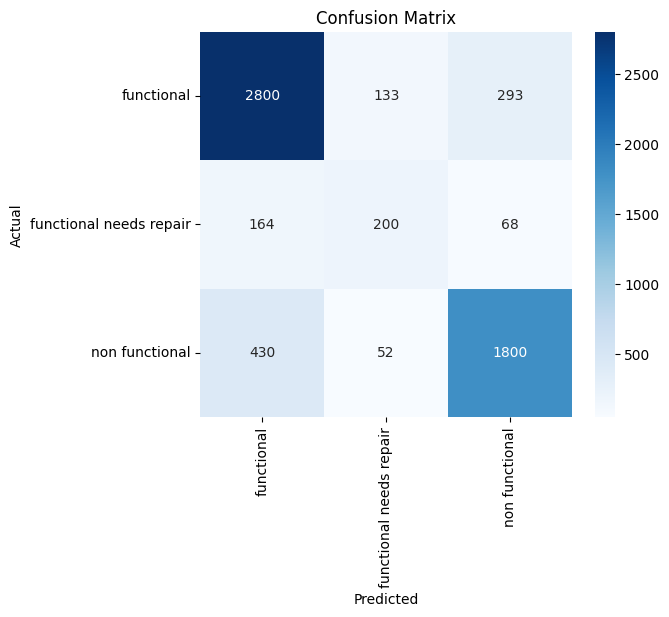


🔍 Class distribution comparison:
Predicted: 0    0.571380
1    0.064815
2    0.363805
Name: proportion, dtype: float64
True:      0    0.543098
1    0.072727
2    0.384175
Name: proportion, dtype: float64


In [27]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, log_loss,
    roc_auc_score, cohen_kappa_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Label decoding if needed
y_true = y_test_encoded
y_pred_labels = y_pred  # use inverse_transform(y_pred) if label encoded
y_proba = full_pipeline.predict_proba(X_test)  # must be available for log_loss/roc_auc

# Basic Scores
print("📊 Accuracy:", accuracy_score(y_true, y_pred_labels))
print("🎯 Precision (macro):", precision_score(y_true, y_pred_labels, average='macro'))
print("🎯 Recall (macro):", recall_score(y_true, y_pred_labels, average='macro'))
print("🎯 F1 Score (macro):", f1_score(y_true, y_pred_labels, average='macro'))
print("🎯 F1 Score (weighted):", f1_score(y_true, y_pred_labels, average='weighted'))

# Cohen's Kappa
print("🧠 Cohen’s Kappa:", cohen_kappa_score(y_true, y_pred_labels))

# Log Loss (requires probabilities)
try:
    print("📉 Log Loss:", log_loss(y_true, y_proba))
except:
    print("⚠️ Log loss not available (no predict_proba)")

# ROC AUC (multiclass)
try:
    print("📈 ROC AUC Score (OvR):", roc_auc_score(y_true, y_proba, multi_class='ovr'))
except:
    print("⚠️ ROC AUC not available (no predict_proba)")

# Classification Report
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=le.classes_))

# Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Prediction Distribution vs True Distribution
print("\n🔍 Class distribution comparison:")
print("Predicted:", pd.Series(y_pred_labels).value_counts(normalize=True).sort_index())
print("True:     ", pd.Series(y_true).value_counts(normalize=True).sort_index())


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

import xgboost as xgb
import lightgbm as lgb

import pandas as pd

# Automatically select column types
numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

# Preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# Define classifiers
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}


In [11]:
from sklearn.pipeline import Pipeline

# Build pipelines
pipelines = {
    name: Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ]) for name, model in models.items()
}


In [12]:
from sklearn.metrics import classification_report
import pandas as pd

results = {}

for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = report["weighted avg"]


Training Decision Tree...


KeyboardInterrupt: 

In [ ]:
import pandas as pd
results_df = pd.DataFrame(results).T
import ace_tools as tools; tools.display_dataframe_to_user(name="Model Evaluation Results", dataframe=results_df)
